In [1]:
# RECOMMENDED TO RESTART KERNEL EACH TIME IF IDS NOT ASSIGNED
# region initializations
import CTEC

# Initialize the traffic behaviour for all vehicles on the road
traffic = CTEC.trafficBehaviour(avg_vehicle_length=4.5,
                                avg_vehicle_buffer=3.6,
                                freeflow_speed=90)

# Initialize the type of vehicles to be added to the road
LD_EV_max_SoC = 70
LD_EV = CTEC.vehicleType(battery_capacity=LD_EV_max_SoC,
                         discharge_rate_freeflow=-20,
                         discharge_rate_jam=-5,
                         vehicleType_ID='LD_EV')

LD_ICE = CTEC.vehicleType(vehicleType_ID = 'LD_ICE')

HD_EV_max_SoC = 500
HD_EV = CTEC.vehicleType(battery_capacity=HD_EV_max_SoC,
                         discharge_rate_freeflow=-150,
                         discharge_rate_jam=-10,
                         vehicleType_ID='HD_EV')

HD_ICE = CTEC.vehicleType(vehicleType_ID = 'HD_ICE')

# Initialize the fast-charging service stations 

# Northbound simulation
'''
S1_NB_LD = CTEC.stationType(vehicleType=LD_EV,
                            off_ramp_location=129, # km
                            on_ramp_location=130, # km
                            max_charging_rate=350, # kW
                            stationType_ID='S1_NB_LD')

S1_NB_HD = CTEC.stationType(vehicleType=HD_EV,
                            off_ramp_location=129, # km
                            on_ramp_location=130, # km
                            max_charging_rate=1000, # kW
                            stationType_ID='S1_NB_HD')

S2_NB_LD = CTEC.stationType(vehicleType=LD_EV,
                            off_ramp_location=260, # km
                            on_ramp_location=261, # km
                            max_charging_rate=350, # kW
                            stationType_ID='S2_NB_LD')

# Initialize an fast-charging service station
S2_NB_HD = CTEC.stationType(vehicleType=HD_EV,
                            off_ramp_location=260, # km
                            on_ramp_location=261, # km
                            max_charging_rate=1000, # kW
                            stationType_ID='S2_NB_HD')
'''
# Southbound simulation
S1_SB_LD = CTEC.stationType(vehicleType=LD_EV,
                            off_ramp_location=218, # km
                            on_ramp_location=219, # km
                            max_charging_rate=350, # kW
                            stationType_ID='S1_SB_LD')

S1_SB_HD = CTEC.stationType(vehicleType=HD_EV,
                            off_ramp_location=218, # km
                            on_ramp_location=219, # km
                            max_charging_rate=1000, # kW
                            stationType_ID='S1_SB_HD')

S2_SB_LD = CTEC.stationType(vehicleType=LD_EV,
                            off_ramp_location=88, # km
                            on_ramp_location=89, # km
                            max_charging_rate=350, # kW
                            stationType_ID='S2_SB_LD')

# Initialize an fast-charging service station
S2_SB_HD = CTEC.stationType(vehicleType=HD_EV,
                            off_ramp_location=88, # km
                            on_ramp_location=89, # km
                            max_charging_rate=1000, # kW
                            stationType_ID='S2_SB_HD')
# endregion


# Set the seed for reproducibility
import numpy as np
np.random.seed(42)
CTEC.verbose = False

import pandas as pd
main_df = pd.read_csv('all_SB_noSoC.csv')
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])

# Group by the date part of the 'Timestamp' without modifying the DataFrame
grouped = main_df.groupby(main_df['Timestamp'].dt.date)

# Now you can iterate over each group
count = 0
result_sims = {}
for date, group_df in grouped:
    count += 1
    #if count == 10:
    #    break

    # Northbound data is in 10 min bins, southbound in 15 min bins
    group_df = CTEC.int_rebin_dataframe(df=group_df, current_bin_size_mins=15, new_bin_size_mins=5)
    
    LD_EV_df = group_df.copy()
    LD_EV_df[LD_EV_df.columns[1]] = LD_EV_df[LD_EV_df.columns[1]] * 1.0*0.95
    LD_EV_df[LD_EV_df.columns[2]] = np.random.uniform(LD_EV_max_SoC*0.9, LD_EV_max_SoC, size=len(LD_EV_df))

    LD_ICE_df = group_df.copy()
    LD_ICE_df[LD_ICE_df.columns[1]] = LD_ICE_df[LD_ICE_df.columns[1]] * 0.0*0.95

    HD_EV_df = group_df.copy()
    HD_EV_df[HD_EV_df.columns[1]] = HD_EV_df[HD_EV_df.columns[1]] * 1.0*0.05
    HD_EV_df[HD_EV_df.columns[2]] = np.random.uniform(HD_EV_max_SoC*0.9, HD_EV_max_SoC, size=len(HD_EV_df))

    HD_ICE_df = group_df.copy()
    HD_ICE_df[HD_ICE_df.columns[1]] = HD_ICE_df[HD_ICE_df.columns[1]] * 0.0*0.05

    # Initialize the road
    road = CTEC.roadScenario(trafficBehaviour=traffic,
                            road_start=0,
                            road_end=350) # km

    road.load_vehicleType(vehicleType=LD_EV, boundary_df_input=LD_EV_df)
    road.load_vehicleType(vehicleType=LD_ICE, boundary_df_input=LD_ICE_df)
    road.load_vehicleType(vehicleType=HD_EV, boundary_df_input=HD_EV_df)
    road.load_vehicleType(vehicleType=HD_ICE, boundary_df_input=HD_ICE_df)
    '''
    road.load_stationType(S1_NB_LD)
    road.load_stationType(S1_NB_HD)
    road.load_stationType(S2_NB_LD)
    road.load_stationType(S2_NB_HD)
    '''
    road.load_stationType(S1_SB_LD)
    road.load_stationType(S1_SB_HD)
    road.load_stationType(S2_SB_LD)
    road.load_stationType(S2_SB_HD)
    
    road.initialize_with_loaded_data()

    CTECsim = CTEC.simulator(roadScenario=road)

    CTECsim.simulate()

    result_sims[date] = CTECsim


In [ ]:
CTECsim.road.vehicleType_dict['LD_EV']['boundary_df'].head(-30)

In [2]:
import pickle

# Pickle the dictionary
with open('SB_100LDHD_5min_350kW.pickle', 'wb') as f:
    pickle.dump(result_sims, f)

In [14]:
# Unpickle the saved dictionary
with open('SB_100LDHD_5min.pickle', 'rb') as f:
    result_sims = pickle.load(f)

In [ ]:
import CTEC
import matplotlib.pyplot as plt

# Initialize the traffic behaviour for all vehicles on the road
traffic = CTEC.trafficBehaviour(avg_vehicle_length=4.5,
                                avg_vehicle_buffer=3.6,
                                freeflow_speed=90)
count = 0
for date in result_sims.keys():
    count += 1
    if count <= 10:
        result_sims[date].road.trafficBehaviour = traffic
        result_sims[date].plot(category = 'stationType_results', instance = 'S1_NB_LD', plotType = 'total_power', width = 8, height = 4)
        #result_sims[date].plot(category = 'vehicleType_results', instance = 'HD_EV', plotType = 'road_SoC', width = 8, height = 4)
        #result_sims[date].plot(category = 'aggregate_density', width = 8, height = 4)

        '''view_offset = 0
        slice_end = -1
        res = result_sims[date].road.road_resolution
        x=((result_sims[date].results_dict['vehicleType_results']['LD_EV']['road_density'].sum(axis=1) + 
        result_sims[date].results_dict['vehicleType_results']['LD_EV_from_S1_SB_LD']['road_density'].sum(axis=1)+
        result_sims[date].results_dict['vehicleType_results']['LD_EV_from_S2_SB_LD']['road_density'].sum(axis=1))*res +
        result_sims[date].results_dict['stationType_results']['S1_SB_LD']['SoC_vehicles'].sum(axis=1)+
        result_sims[date].results_dict['stationType_results']['S1_SB_LD']['SoC_vehicles'].sum(axis=1))

        (result_sims[date].results_dict['vehicleType_results']['LD_EV']['road_density'].sum(axis=1)*res-view_offset)[:slice_end].plot()
        (result_sims[date].results_dict['vehicleType_results']['LD_EV_from_S1_SB_LD']['road_density'].sum(axis=1)*res)[:slice_end].plot()
        (result_sims[date].results_dict['vehicleType_results']['LD_EV_from_S2_SB_LD']['road_density'].sum(axis=1)*res)[:slice_end].plot()
        result_sims[date].results_dict['stationType_results']['S1_SB_LD']['SoC_vehicles'].sum(axis=1)[:slice_end].plot()
        result_sims[date].results_dict['stationType_results']['S2_SB_LD']['SoC_vehicles'].sum(axis=1)[:slice_end].plot()

        (x[:slice_end]-view_offset).plot()

        # Optional: Enhancements for better visualization
        plt.title('Total EVs on the road')
        plt.xlabel('Time')
        plt.ylabel('EVs')
        plt.grid(True)

        # Display the plot
        plt.show()'''
        #break

In [24]:
for date in result_sims.keys():
    print(result_sims[date].road.stationType_dict['S1_NB_LD']['min_SoC_to_next_station'],
        result_sims[date].road.stationType_dict['S1_NB_HD']['min_SoC_to_next_station'],
        result_sims[date].road.stationType_dict['S2_NB_LD']['min_SoC_to_next_station'],
        result_sims[date].road.stationType_dict['S2_NB_HD']['min_SoC_to_next_station'])
    break

0.0 206.7117117117117 0.0 148.33333333333334


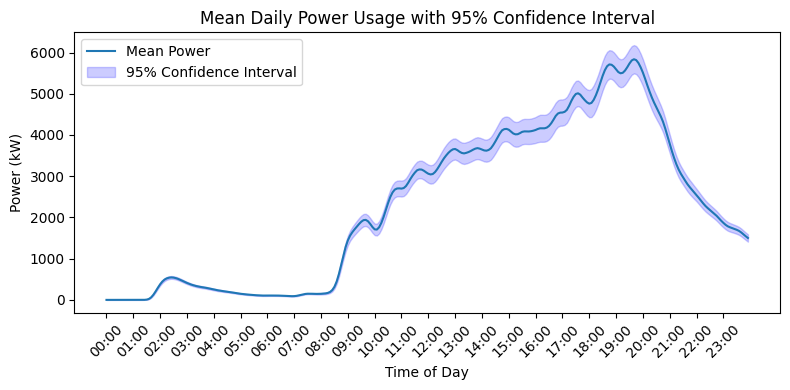

In [47]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to load datasets
def load_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Loading the datasets
#result_sims_NB = load_dataset('NB_10percent_5min.pickle')
#result_sims_SB = load_dataset('SB_10percent_5min.pickle')

all_data = []

for date, obj in result_sims_NB_150kW.items():
    df = obj.results_dict['stationType_results']['S1_NB_HD']['total_power'].copy()
    df.index = pd.to_datetime(df.index).time  # Convert datetime to just time if needed
    df['Date'] = date
    all_data.append(df)

#region
combined_df = pd.concat(all_data).reset_index().rename(columns={'index': 'Time'})
stats_df = combined_df.groupby('Time').agg(
    Mean=('total_power', 'mean'),
    SEM=('total_power', 'sem')  # Standard Error of the Mean
)
# Z-scores for 95% and 90% confidence intervals
z_95 = 1.96  # Approximation for 95%
#z_90 = 1.645  # Approximation for 90%
stats_df['95% CI Lower'] = stats_df['Mean'] - z_95 * stats_df['SEM']
stats_df['95% CI Upper'] = stats_df['Mean'] + z_95 * stats_df['SEM']
#stats_df['90% CI Lower'] = stats_df['Mean'] - z_90 * stats_df['SEM']
#stats_df['90% CI Upper'] = stats_df['Mean'] + z_90 * stats_df['SEM']

# Generate a numerical sequence for the x-axis
x_values = range(len(stats_df))
time_labels = [time.strftime('%H:%M') for time in stats_df.index]  # Reformat if necessary

# Determine indices for every hour (or another interval if preferred)
hour_ticks = [i for i, label in enumerate(time_labels) if label.endswith(':00')]

plt.figure(figsize=(8, 4))
plt.plot(x_values, stats_df['Mean'], label='Mean Power')
plt.fill_between(x_values, stats_df['95% CI Lower'], stats_df['95% CI Upper'], color='b', alpha=0.2, label='95% Confidence Interval')



#plt.fill_between(x_values, stats_df['90% CI Lower'], stats_df['90% CI Upper'], color='b', alpha=0.2, label='90% Confidence Interval')
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Mean Daily Power Usage with 95% Confidence Interval')

# Set x-ticks to only include the selected indices
plt.xticks(ticks=hour_ticks, labels=[time_labels[i] for i in hour_ticks], rotation=45)

plt.legend() 
plt.tight_layout()
plt.show()
#endregion


In [1]:
import postprocessing as pp

# Loading the datasets
result_sims_NB_10 = pp.load_dataset('NB_10percent_5min.pickle')
result_sims_SB_10 = pp.load_dataset('SB_10percent_5min.pickle')
result_sims_NB_100 = pp.load_dataset('NB_100LD_5min.pickle')
result_sims_SB_100 = pp.load_dataset('SB_100LD_5min.pickle')
result_sims_NB_all = pp.load_dataset('NB_100LDHD_5min.pickle')
result_sims_SB_all = pp.load_dataset('SB_100LDHD_5min.pickle')
result_sims_NB_150kW = pp.load_dataset('NB_100LDHD_5min_150kW.pickle')
result_sims_SB_150kW = pp.load_dataset('SB_100LDHD_5min_150kW.pickle')
result_sims_NB_350kW = pp.load_dataset('NB_100LDHD_5min_350kW.pickle')
result_sims_SB_350kW = pp.load_dataset('SB_100LDHD_5min_350kW.pickle')

# Process and sum the data
power_10 = pp.process_and_sum_data(result_sims_NB_10, result_sims_SB_10)
power_100 = pp.process_and_sum_data(result_sims_NB_100, result_sims_SB_100)
power_all = pp.process_and_sum_data(result_sims_NB_all, result_sims_SB_all)
power_150kW = pp.process_and_sum_data(result_sims_NB_150kW, result_sims_SB_150kW)
power_350kW = pp.process_and_sum_data(result_sims_NB_350kW, result_sims_SB_350kW)
count_all = pp.process_and_sum_data(result_sims_NB_all, result_sims_SB_all, result_type='total_EVs_charging')
count_150kW = pp.process_and_sum_data(result_sims_NB_150kW, result_sims_SB_150kW, result_type='total_EVs_charging')
count_350kW = pp.process_and_sum_data(result_sims_NB_350kW, result_sims_SB_350kW, result_type='total_EVs_charging')

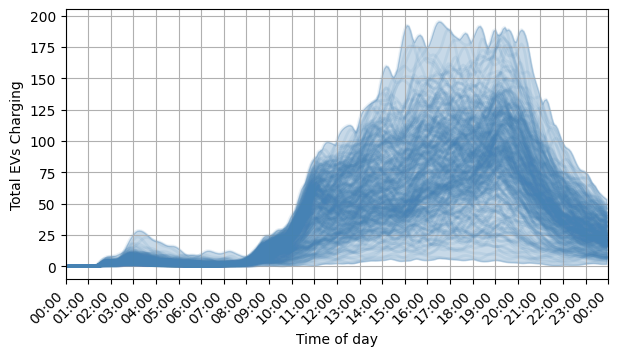

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import postprocessing as pp

df = count_350kW['LDHD_S1']

def plot_every_day(df, result_type='total_power', width=7, height=3.5, 
                   line_color='blue', line_width=2, transparency=0.5):
    # Group the data by day and plot each group
    fig, ax = plt.subplots(figsize=(width, height))

    # Group by time and calculate min and max
    bounds = df.groupby(df.index.time)[result_type].agg(['min', 'max'])
    
    # Create a datetime index for the bounds with the time normalized
    common_date = pd.Timestamp('1900-01-01')
    bounds.index = [common_date.replace(hour=dt.hour, minute=dt.minute, second=dt.second) for dt in bounds.index]

    # Plot the bounds with the fill_between method
    ax.fill_between(bounds.index, bounds['min'], bounds['max'], color=line_color, alpha=transparency*3)

    # Normalize the time to a specific date, for overlapping
    for (year, month, day), group in df.groupby([df.index.year, df.index.month, df.index.day]):
        # Create a new datetime index for the group with a common date (e.g., 1900-01-01)
        group.index = group.index.map(lambda dt: dt.replace(year=1900, month=1, day=1))
        # Plot with specified color, linewidth, and transparency
        ax.plot(group.index, group[result_type], color=line_color, linewidth=line_width, alpha=transparency)

    # Beautify the x-axis to show hours and minutes
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Show only the x-axis labels for the hours
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Set limits to only show one day
    ax.set_xlim([pd.Timestamp('1900-01-01 00:00:00'), pd.Timestamp('1900-01-02 00:00:00')])

    # Adding labels and title
    plt.xlabel('Time of day')
    if result_type == 'total_power':
        plt.ylabel('Total Power, kW')
    elif result_type == 'total_EVs_charging':
        plt.ylabel('Total EVs Charging')

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()


plot_every_day(df, result_type='total_EVs_charging', transparency=0.10, line_color='steelblue', line_width=2)

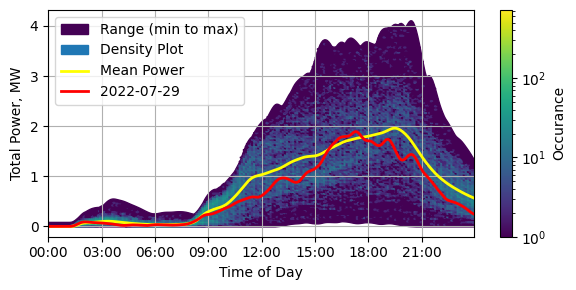

In [128]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df = power_10['LDHD_S1'].copy()

# Normalize the time to a specific date for plotting
df['time_of_day'] = df.index.map(lambda dt: dt.replace(year=1900, month=1, day=1))

# Group by 'time_of_day' and calculate mean, min, max
grouped = df.groupby(df['time_of_day'])
mean_power = grouped['total_power'].mean()/1000
adjustment=0.09
min_power = (grouped['total_power'].min()/1000 - adjustment).clip(lower=0)
max_power = grouped['total_power'].max()/1000+adjustment

# Prepare x values as numerical dates
mean_times = mdates.date2num(mean_power.index)

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

# Fill between the min and max power
ax.fill_between(mean_times, min_power, max_power, color=plt.cm.viridis(0), alpha=1, label='Range (min to max)')

# Create a hexbin plot of the time and power
x = mdates.date2num(df['time_of_day'])
y = df['total_power'].values/1000
ny=12*10
hb = ax.hexbin(x, y, gridsize=(int(np.sqrt(3)*ny),ny), cmap='viridis', bins='log', mincnt=1, label='Density Plot')

# Overlay the mean power consumption as a line plot
ax.plot(mean_times, mean_power, color='yellow', lw=2, label='Mean Power')

# Add a particular day
particular_day = '2022-07-29'  # Change to your specific date
mask = (df.index.date == pd.to_datetime(particular_day).date())
particular_day_df = df[mask]
particular_day_x = mdates.date2num(particular_day_df['time_of_day'])
particular_day_y = particular_day_df['total_power']/1000

# Plot the particular day as a line on top
ax.plot(particular_day_x, particular_day_y, color='red', lw=2, label=particular_day)

# Beautify the x-axis to show hours and minutes
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set limits to only show one day
ax.set_xlim([mean_times[0], mean_times[-1]])

# Add colorbar to show the count in bins
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Occurance')

# Adding labels and title
plt.xlabel('Time of Day')
plt.ylabel('Total Power, MW')

# Show the legend
legend = ax.legend(loc='upper left')

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


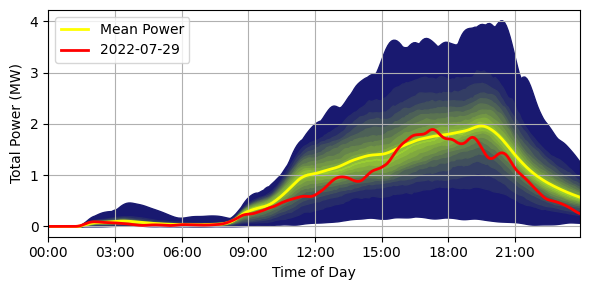

In [58]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

df = power_10['LDHD_S1'].copy()

# Normalize the time to a specific date for plotting
df['time_of_day'] = df.index.map(lambda dt: dt.replace(year=1900, month=1, day=1))

# Group by 'time_of_day' and calculate mean
grouped = df.groupby('time_of_day')['total_power']

# Prepare x values as numerical dates
x_values = mdates.date2num(grouped.mean().index)

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

# Define the percentile ranges you want to plot
percentile_ranges = [(i, 100 - i) for i in range(0, 50 + 1, 5)]

# Define the colormap
cmap = mcolors.LinearSegmentedColormap.from_list('custom_blue_yellow', ['midnightblue', 'yellowgreen'], N=len(percentile_ranges))

# Calculate and plot the percentile ranges
for i, (lower, upper) in enumerate(percentile_ranges):
    color = cmap(i / (len(percentile_ranges) - 1))  # Get the color from the colormap
    lower_bound = grouped.quantile(lower / 100.0) / 1000  # Convert to MW
    upper_bound = grouped.quantile(upper / 100.0) / 1000  # Convert to MW
    ax.fill_between(x_values, lower_bound, upper_bound, color=color, alpha=1) #, label=f'{lower}-{upper} percentile')

# Overlay the mean power consumption as a line plot
mean_power = grouped.mean() / 1000  # Convert to MW
ax.plot(x_values, mean_power, color='yellow', lw=2, label='Mean Power')

# Add a particular day
particular_day = '2022-07-29'  # Change to your specific date
mask = (df.index.date == pd.to_datetime(particular_day).date())
particular_day_df = df[mask]
particular_day_x = mdates.date2num(particular_day_df['time_of_day'])
particular_day_y = particular_day_df['total_power']/1000

# Plot the particular day as a line on top
ax.plot(particular_day_x, particular_day_y, color='red', lw=2, label=particular_day)

# Beautify the x-axis to show hours and minutes
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set limits to only show one day
ax.set_xlim([x_values[0], x_values[-1]])

# Adding labels and title
plt.xlabel('Time of Day')
plt.ylabel('Total Power (MW)')

# Show the legend
legend = ax.legend(loc='upper left')

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

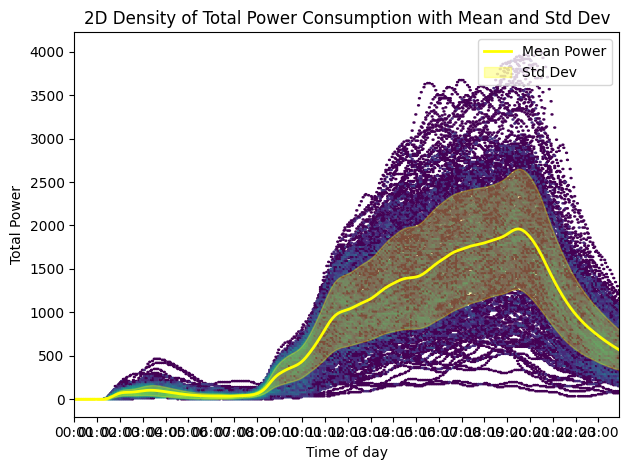

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Normalize the time to a specific date for plotting
df['time_of_day'] = df.index.map(lambda dt: dt.replace(year=1900, month=1, day=1))

# Calculate the mean and standard deviation for each time slot
stats_df = df.groupby(df['time_of_day']).agg(['mean', 'std'])

# Plotting
fig, ax = plt.subplots()

# Create a hexbin plot
x = mdates.date2num(df['time_of_day'])
y = df['total_power'].values
ax.hexbin(x, y, gridsize=300, cmap='viridis', bins='log', mincnt=1)

# Plot the mean power consumption
mean_times = mdates.date2num(stats_df.index)
mean_power = stats_df['total_power']['mean']
ax.plot(mean_times, mean_power, color='yellow', lw=2, label='Mean Power')

# Plot the standard deviation range
std_power = stats_df['total_power']['std']
ax.fill_between(mean_times, mean_power - std_power, mean_power + std_power, color='yellow', alpha=0.3, label='Std Dev')

# Format the x-axis to show hours and minutes
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set limits to only show one day
ax.set_xlim([mean_times[0], mean_times[-1]])

# Labels, title, and legend
plt.xlabel('Time of day')
plt.ylabel('Total Power')
plt.title('2D Density of Total Power Consumption with Mean and Std Dev')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


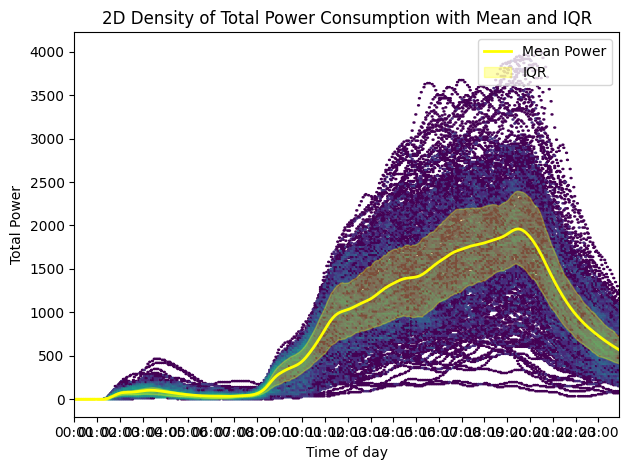

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Normalize the time to a specific date for plotting
df['time_of_day'] = df.index.map(lambda dt: dt.replace(year=1900, month=1, day=1))

# Calculate the mean, 25th percentile (Q1), and 75th percentile (Q3) for each time slot
stats_df = df.groupby(df['time_of_day'])['total_power'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
stats_df.columns = ['mean', 'Q1', 'Q3']

# Plotting
fig, ax = plt.subplots()

# Create a hexbin plot
x = mdates.date2num(df['time_of_day'])
y = df['total_power'].values
ax.hexbin(x, y, gridsize=300, cmap='viridis', bins='log', mincnt=1)

# Plot the mean power consumption
mean_times = mdates.date2num(stats_df.index)
mean_power = stats_df['mean']
ax.plot(mean_times, mean_power, color='yellow', lw=2, label='Mean Power')

# Plot the IQR range
ax.fill_between(mean_times, stats_df['Q1'], stats_df['Q3'], color='yellow', alpha=0.3, label='IQR')

# Format the x-axis to show hours and minutes
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set limits to only show one day
ax.set_xlim([mean_times[0], mean_times[-1]])

# Labels, title, and legend
plt.xlabel('Time of day')
plt.ylabel('Total Power')
plt.title('2D Density of Total Power Consumption with Mean and IQR')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


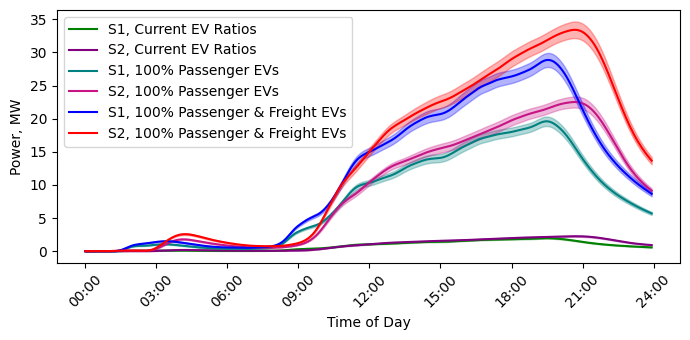

In [2]:
import numpy as np
import scipy.stats as stats

def prepare_data_for_time_steps(combined_data, key):
    """
    Prepare data by calculating the mean and 95% CI for each time step within the specified key.
    """
    data = combined_data[key]  # Extract data for the specified key
    # Calculate mean and 95% CI for each time step
    means = data.groupby(data.index.time).mean()
    sems = data.groupby(data.index.time).sem()
    ci_lowers = means - 1.96 * sems
    ci_uppers = means + 1.96 * sems
    
    return means, ci_lowers, ci_uppers

import matplotlib.pyplot as plt

# Colors and shades: Two colors, each with three shades
colors = {'S1': 'blue', 'S2': 'purple'}
shades = ['light', 'medium', 'dark']
shade_amounts = {'10': 1.6, '100': 1.3, 'all': 1.0}  # Example adjustments

# Function to adjust color brightness
def adjust_color_brightness(color, amount=1.0):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.to_rgb(color)
    except:
        c = color
    c = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3.5))
def plot_data(means, ci_lowers, ci_uppers, label, color, amount = None):
    """
    Plot the mean and 95% CI for each time step.
    """
    x_values = range(len(means))

    # Plot mean
    if amount is not None:
        color = adjust_color_brightness(color, amount)
    ax.plot(x_values, means/1000, label=label, color=color)
    # Plot 95% CI
    ax.fill_between(x_values, ci_lowers['total_power']/1000, ci_uppers['total_power']/1000, color=color, alpha=0.3)

    # Number of points per hour (12 for 5-minute intervals)
    points_per_hour = 12

    # Hours at which you want ticks
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24

    # Calculate tick positions based on the number of points per hour
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]

    # Define labels for these ticks
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']

    plt.xticks(ticks=tick_positions, labels=labels, rotation=45)

# Example plotting call for "LDHD_S1" in scenario '10'
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_10, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, 'S1, Current EV Ratios', 'green')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_10, 'LDHD_S2')
plot_data(means, ci_lowers, ci_uppers, 'S2, Current EV Ratios', 'purple')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_100, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, 'S1, 100% Passenger EVs', 'teal')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_100, 'LDHD_S2')
plot_data(means, ci_lowers, ci_uppers, 'S2, 100% Passenger EVs', 'mediumvioletred')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_all, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, 'S1, 100% Passenger & Freight EVs', 'blue')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_all, 'LDHD_S2')
plot_data(means, ci_lowers, ci_uppers, 'S2, 100% Passenger & Freight EVs', 'red')

plt.xlabel('Time of Day')
plt.ylabel('Power, MW')
#plt.title('Power Usage Across Scenarios and Stations')
plt.legend()
plt.tight_layout()
plt.show()


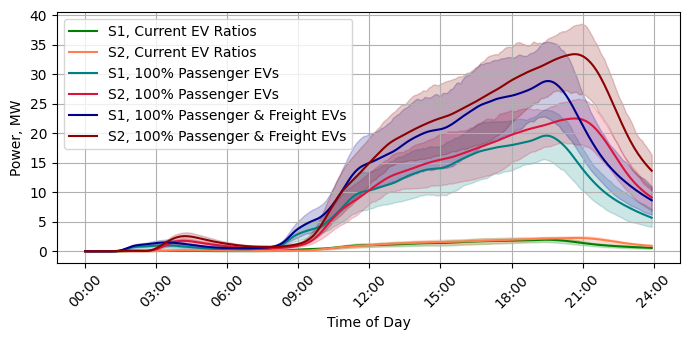

In [100]:
import numpy as np
import scipy.stats as stats

def prepare_data_for_time_steps(combined_data, key):
    """
    Prepare data by calculating the mean and IQR for each time step within the specified key.
    """
    data = combined_data[key]  # Extract data for the specified key
    # Calculate mean and IQR for each time step
    means = data.groupby(data.index.time).mean()
    q1 = data.groupby(data.index.time).quantile(0.25)
    q3 = data.groupby(data.index.time).quantile(0.75)
    
    return means, q1, q3

import matplotlib.pyplot as plt

# Colors and shades: Two colors, each with three shades
colors = {'S1': 'blue', 'S2': 'purple'}
shades = ['light', 'medium', 'dark']
shade_amounts = {'10': 1.6, '100': 1.3, 'all': 1.0}  # Example adjustments

# Function to adjust color brightness
def adjust_color_brightness(color, amount=1.0):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.to_rgb(color)
    except:
        c = color
    c = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3.5))
def plot_data(means, q1, q3, label, color, amount = None):
    """
    Plot the mean and 95% CI for each time step.
    """
    x_values = range(len(means))

    # Plot mean
    if amount is not None:
        color = adjust_color_brightness(color, amount)
    ax.plot(x_values, means/1000, label=label, color=color)
    # Plot 95% CI
    ax.fill_between(x_values, q1['total_power']/1000, q3['total_power']/1000, color=color, alpha=0.2)

    # Number of points per hour (12 for 5-minute intervals)
    points_per_hour = 12

    # Hours at which you want ticks
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24

    # Calculate tick positions based on the number of points per hour
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]

    # Define labels for these ticks
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']

    plt.xticks(ticks=tick_positions, labels=labels, rotation=45)

# Example plotting call for "LDHD_S1" in scenario '10'
means, q1, q3 = prepare_data_for_time_steps(power_10, 'LDHD_S1')
plot_data(means, q1, q3, 'S1, Current EV Ratios', 'green')
means, q1, q3 = prepare_data_for_time_steps(power_10, 'LDHD_S2')
plot_data(means, q1, q3, 'S2, Current EV Ratios', 'coral')
means, q1, q3 = prepare_data_for_time_steps(power_100, 'LDHD_S1')
plot_data(means, q1, q3, 'S1, 100% Passenger EVs', 'teal')
means, q1, q3 = prepare_data_for_time_steps(power_100, 'LDHD_S2')
plot_data(means, q1, q3, 'S2, 100% Passenger EVs', 'crimson')
means, q1, q3 = prepare_data_for_time_steps(power_all, 'LDHD_S1')
plot_data(means, q1, q3, 'S1, 100% Passenger & Freight EVs', 'darkblue')
means, q1, q3 = prepare_data_for_time_steps(power_all, 'LDHD_S2')
plot_data(means, q1, q3, 'S2, 100% Passenger & Freight EVs', 'darkred')

plt.xlabel('Time of Day')
plt.ylabel('Power, MW')
#plt.title('Power Usage Across Scenarios and Stations')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


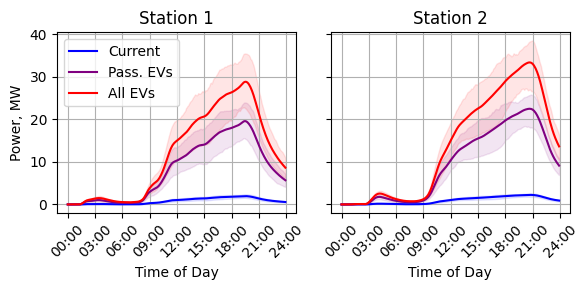

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

def adjust_color_brightness(color, amount=1.0):
    """Adjust the brightness of the given color."""
    c = mc.to_rgb(color)  # Convert color to RGB format
    c = colorsys.rgb_to_hls(*c)  # Convert RGB to HLS
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])  # Adjust luminance and convert back to RGB

def prepare_data_for_time_steps(combined_data, key):
    """Prepare data by calculating the mean and IQR for each time step within the specified key."""
    data = combined_data[key]  # Extract data for the specified key
    means = data.groupby(data.index.time).mean()
    q1 = data.groupby(data.index.time).quantile(0.25)
    q3 = data.groupby(data.index.time).quantile(0.75)
    return means, q1, q3

def plot_data(ax, means, q1, q3, label, color):
    """Plot the mean and IQR for each time step."""
    x_values = range(len(means))
    ax.plot(x_values, means/1000, label=label, color=color)
    ax.fill_between(x_values, q1['total_power']/1000, q3['total_power']/1000, color=color, alpha=0.1)
    
    # Define x-axis ticks and labels
    points_per_hour = 12  # Number of points per hour (12 for 5-minute intervals)
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']
    ax.set_xticks(ticks=tick_positions, labels=labels)
    ax.tick_params(axis='x', rotation=45)

# Setup for subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)

# Colors for each scenario
scenario_colors = ['blue', 'purple', 'red']  # Define once for consistency across plots

# Data and plotting for each station
stations = ['LDHD_S1', 'LDHD_S2']
scenarios = [(power_10, 'Current'), (power_100, 'Pass. EVs'), (power_all, 'All EVs')]

for idx, ax in enumerate(axs):
    station = stations[idx]
    for color_idx, (scenario, label_suffix) in enumerate(scenarios):
        means, q1, q3 = prepare_data_for_time_steps(scenario, station)
        plot_data(ax, means, q1, q3, f'{label_suffix}', scenario_colors[color_idx])

# Common elements
axs[0].set_title('Station 1')
axs[1].set_title('Station 2')
axs[0].set_xlabel('Time of Day')
axs[1].set_xlabel('Time of Day')
axs[0].set_ylabel('Power, MW')
count=0
for ax in axs:
    count+=1
    ax.grid(True)
    if count==2: break
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


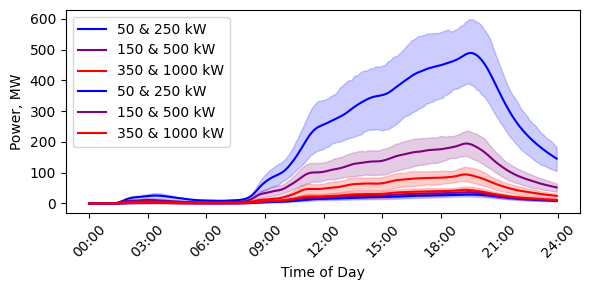

In [8]:
def prepare_data_for_time_steps(combined_data, key):
    """
    Prepare data by calculating the mean and IQR for each time step within the specified key.
    """
    data = combined_data[key].copy()  # Extract data for the specified key
    # Calculate mean and IQR for each time step
    means = data.groupby(data.index.time).mean()
    q1 = data.groupby(data.index.time).quantile(0.25)
    q3 = data.groupby(data.index.time).quantile(0.75)
    
    return means, q1, q3

import matplotlib.pyplot as plt

# Colors and shades: Two colors, each with three shades
colors = {'S1': 'blue', 'S2': 'purple'}
shades = ['light', 'medium', 'dark']
shade_amounts = {'10': 1.6, '100': 1.3, 'all': 1.0}  # Example adjustments

# Function to adjust color brightness
def adjust_color_brightness(color, amount=1.0):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.to_rgb(color)
    except:
        c = color
    c = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Plotting
import matplotlib.pyplot as plt

def plot_data(means, q1, q3, label, color, amount = None, plotType='power'):
    """
    Plot the mean and 95% CI for each time step.
    """
    x_values = range(len(means))

    if plotType == 'power': 
        column = 'total_power'
        means /= 1000
        q1[column] /= 1000
        q3[column] /= 1000
    elif plotType == 'count': 
        column = 'total_EVs_charging'

    # Plot mean
    if amount is not None:
        color = adjust_color_brightness(color, amount)
    ax.plot(x_values, means, label=label, color=color)
    # Plot IQR
    
    ax.fill_between(x_values, q1[column], q3[column], color=color, alpha=0.2)

    # Number of points per hour (12 for 5-minute intervals)
    points_per_hour = 12

    # Hours at which you want ticks
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24

    # Calculate tick positions based on the number of points per hour
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]

    # Define labels for these ticks
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']

    plt.xticks(ticks=tick_positions, labels=labels, rotation=45)

fig, ax = plt.subplots(figsize=(6, 3))
# Subplot 1
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_all, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '50 & 250 kW', 'blue', plotType='count')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_150kW, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '150 & 500 kW', 'purple', plotType='count')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_350kW, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '350 & 1000 kW', 'red', plotType='count')
# Subplot 2
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_all, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '50 & 250 kW', 'blue', plotType='power')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_150kW, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '150 & 500 kW', 'purple', plotType='power')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_350kW, 'LDHD_S1')
plot_data(means, ci_lowers, ci_uppers, '350 & 1000 kW', 'red', plotType='power')

plt.xlabel('Time of Day')
plt.ylabel('Power, MW')
#plt.title('Power Usage Across Scenarios and Stations')
plt.legend()
plt.tight_layout()
plt.show()

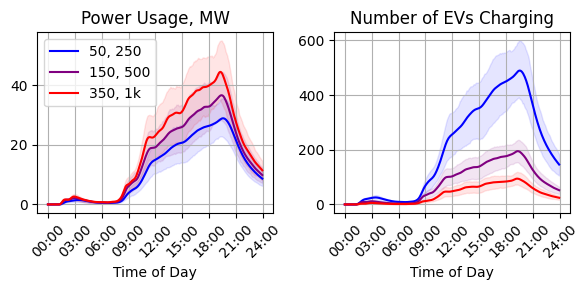

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

def adjust_color_brightness(color, amount=1.0):
    """ Adjust color brightness. """
    c = mc.to_rgb(color)
    c = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def prepare_data_for_time_steps(combined_data, key):
    """ Calculate mean and IQR for each time step. """
    data = combined_data[key].copy()
    means = data.groupby(data.index.time).mean()
    q1 = data.groupby(data.index.time).quantile(0.25)
    q3 = data.groupby(data.index.time).quantile(0.75)
    return means, q1, q3

def plot_data(ax, means, q1, q3, label, color, amount=None, plotType='power'):
    """ Plot data with means and IQR on given axes. """
    x_values = range(len(means))
    column = 'total_power' if plotType == 'power' else 'total_EVs_charging'

    if plotType == 'power':
        means /= 1000
        q1[column] /= 1000
        q3[column] /= 1000

    if amount is not None:
        color = adjust_color_brightness(color, amount)
    ax.plot(x_values, means, label=label, color=color)
    ax.fill_between(x_values, q1[column], q3[column], color=color, alpha=0.1)

    # Set ticks and labels
    points_per_hour = 12
    hours_for_ticks = list(range(0, 25, 3))
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']
    ax.set_xticks(ticks=tick_positions)
    ax.set_xticklabels(labels, rotation=45)

# Setup two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

# Plot data for 'power'
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_all, 'LDHD_S1')
plot_data(ax1, means, ci_lowers, ci_uppers, '50, 250', 'blue', plotType='power')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_150kW, 'LDHD_S1')
plot_data(ax1, means, ci_lowers, ci_uppers, '150, 500', 'purple', plotType='power')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(power_350kW, 'LDHD_S1')
plot_data(ax1, means, ci_lowers, ci_uppers, '350, 1k', 'red', plotType='power')

ax1.set_title('Power Usage, MW')
ax1.set_xlabel('Time of Day')
ax1.grid()

# Plot data for 'count'
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_all, 'LDHD_S1')
plot_data(ax2, means, ci_lowers, ci_uppers, '50, 250', 'blue', plotType='count')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_150kW, 'LDHD_S1')
plot_data(ax2, means, ci_lowers, ci_uppers, '150, 500', 'purple', plotType='count')
means, ci_lowers, ci_uppers = prepare_data_for_time_steps(count_350kW, 'LDHD_S1')
plot_data(ax2, means, ci_lowers, ci_uppers, '350, 1k', 'red', plotType='count')

ax2.set_title('Number of EVs Charging')
ax2.set_xlabel('Time of Day')
ax2.grid()

# Add legends
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()


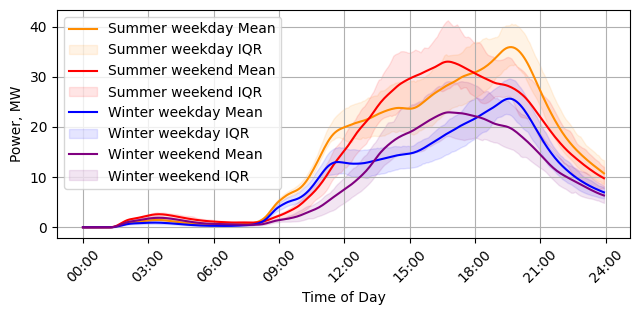

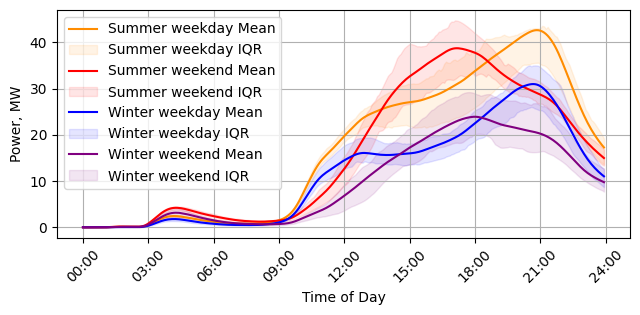

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def categorize_season_daytype(date):
    month = date.month
    day_of_week = date.weekday()  # Monday=0, Sunday=6
    
    # Define summer as May to October (inclusive), otherwise winter
    season = 'summer' if 5 <= month <= 10 else 'winter'
    
    # Weekdays (Mon-Fri) vs. weekends (Sat-Sun)
    day_type = 'weekday' if day_of_week < 5 else 'weekend'
    
    return f'{season}_{day_type}'

def plot_seasonal_results(df):
    # Ensure df has 'Season_DayType' categorized
    df['Season_DayType'] = df.index.map(lambda date: categorize_season_daytype(date))

    # Extract just the time part of the DateTimeIndex
    df['Time'] = df.index.time

    # Now, group by both 'Season_DayType' and 'Time'
    stats_df = df.groupby(['Season_DayType', 'Time']).agg(
        Mean=('total_power', 'mean'),
        Q1=('total_power', lambda x: np.percentile(x, 25)),
        Q3=('total_power', lambda x: np.percentile(x, 75))
        #SEM=('total_power', 'sem'),
        #Quantile_75=('total_power', lambda x: np.percentile(x, 75))
    )

    '''# Calculate 95% CI as before
    z_95 = 1.96
    stats_df['95% CI Lower'] = stats_df['Mean'] - z_95 * stats_df['SEM']
    stats_df['95% CI Upper'] = stats_df['Mean'] + z_95 * stats_df['SEM']'''

    # Reset index for plotting
    stats_df.reset_index(inplace=True)

    plt.figure(figsize=(6.5, 3.25))

    # Define categories and colors for clarity in differentiation
    categories_colors = {
        'summer_weekday': 'darkorange',
        'summer_weekend': 'red',
        'winter_weekday': 'blue',
        'winter_weekend': 'purple'
    }

    for category, color in categories_colors.items():
        cat_df = stats_df[stats_df['Season_DayType'] == category]
        x_values = range(len(cat_df))
        plt.plot(x_values, cat_df['Mean']/1000, label=f'{category.replace("_", " ").capitalize()} Mean', color=color)
        plt.fill_between(x_values, cat_df['Q1']/1000, cat_df['Q3']/1000, color=color, alpha=0.1, label=f'{category.replace("_", " ").capitalize()} IQR')
        #plt.fill_between(x_values, cat_df['95% CI Lower']/1000, cat_df['95% CI Upper']/1000, color=color, alpha=0.2, label=f'{category.replace("_", " ").capitalize()} 95% CI')
        #plt.plot(x_values, cat_df['Quantile_75'], label=f'{category.replace("_", " ").capitalize()} 75th Percentile', linestyle='--', color=color)
        
    plt.xlabel('Time of Day')
    plt.ylabel('Power, MW')
    #plt.title('Expected Demand by Season and Day Type')

    # Number of points per hour (12 for 5-minute intervals)
    points_per_hour = 12

    # Hours at which you want ticks
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24

    # Calculate tick positions based on the number of points per hour
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]

    # Define labels for these ticks
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']

    plt.xticks(ticks=tick_positions, labels=labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

plot_seasonal_results(power_all['LDHD_S1'].copy())
plot_seasonal_results(power_all['LDHD_S2'].copy())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


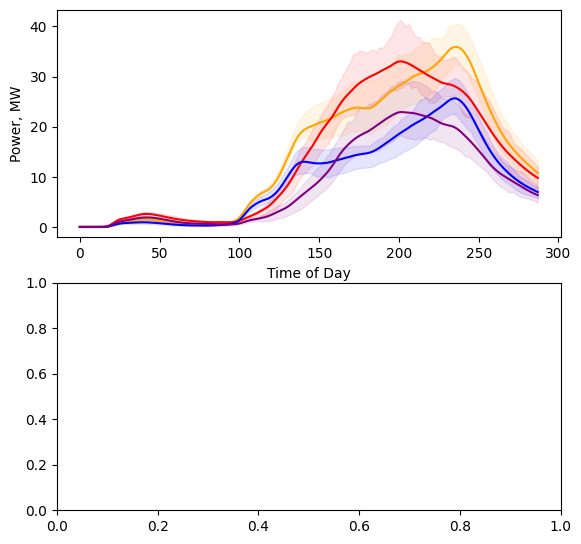

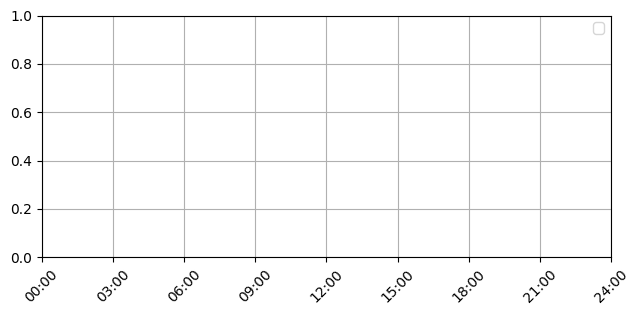

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


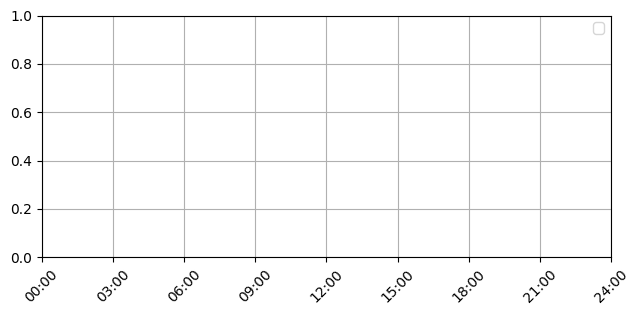

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def categorize_season_daytype(date):
    month = date.month
    day_of_week = date.weekday()  # Monday=0, Sunday=6
    
    # Define summer as May to October (inclusive), otherwise winter
    season = 'summer' if 5 <= month <= 10 else 'winter'
    
    # Weekdays (Mon-Fri) vs. weekends (Sat-Sun)
    day_type = 'weekday' if day_of_week < 5 else 'weekend'
    
    return f'{season}_{day_type}'

def plot_seasonal_results(df, ax):
    # Ensure df has 'Season_DayType' categorized
    df['Season_DayType'] = df.index.map(lambda date: categorize_season_daytype(date))

    # Extract just the time part of the DateTimeIndex
    df['Time'] = df.index.time

    # Now, group by both 'Season_DayType' and 'Time'
    stats_df = df.groupby(['Season_DayType', 'Time']).agg(
        Mean=('total_power', 'mean'),
        Q1=('total_power', lambda x: np.percentile(x, 25)),
        Q3=('total_power', lambda x: np.percentile(x, 75))
        #SEM=('total_power', 'sem'),
        #Quantile_75=('total_power', lambda x: np.percentile(x, 75))
    )

    '''# Calculate 95% CI as before
    z_95 = 1.96
    stats_df['95% CI Lower'] = stats_df['Mean'] - z_95 * stats_df['SEM']
    stats_df['95% CI Upper'] = stats_df['Mean'] + z_95 * stats_df['SEM']'''

    # Reset index for plotting
    stats_df.reset_index(inplace=True)

    plt.figure(figsize=(6.5, 3.25))

    # Define categories and colors for clarity in differentiation
    categories_colors = {
        'summer_weekday': 'orange',
        'summer_weekend': 'red',
        'winter_weekday': 'blue',
        'winter_weekend': 'purple'
    }

    for category, color in categories_colors.items():
        cat_df = stats_df[stats_df['Season_DayType'] == category]
        x_values = range(len(cat_df))
        ax.plot(x_values, cat_df['Mean']/1000, label=f'{category.replace("_", " ").capitalize()} Mean', color=color, zorder=3)
        ax.fill_between(x_values, cat_df['Q1']/1000, cat_df['Q3']/1000, color=color, alpha=0.1, label=f'{category.replace("_", " ").capitalize()} IQR', zorder=2)
        #ax.plot(x_values, cat_df['Q1']/1000, label=f'{category.replace("_", " ").capitalize()} Q1', color=color, linestyle='--', linewidth=1, zorder=1)
        #ax.plot(x_values, cat_df['Q3']/1000, label=f'{category.replace("_", " ").capitalize()} Q3', color=color, linestyle='--', linewidth=1, zorder=1)
        
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Power, MW')
    #plt.title('Expected Demand by Season and Day Type')

    # Number of points per hour (12 for 5-minute intervals)
    points_per_hour = 12

    # Hours at which you want ticks
    hours_for_ticks = list(range(0, 25, 3))  # 0, 3, 6, ..., 24

    # Calculate tick positions based on the number of points per hour
    tick_positions = [hour * points_per_hour for hour in hours_for_ticks]

    # Define labels for these ticks
    labels = [f'{hour:02d}:00' for hour in hours_for_ticks[:-1]] + ['24:00']

    plt.xticks(ticks=tick_positions, labels=labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

# Create two vertical subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6.5, 2*3.25))

# Plot results for both stations on separate subplots
plot_seasonal_results(power_all['LDHD_S1'].copy(), axs[0])
plot_seasonal_results(power_all['LDHD_S2'].copy(), axs[1])

# Adjusting and setting legends for both subplots
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removing duplicate labels
axs[0].legend(by_label.values(), by_label.keys())
axs[1].legend(by_label.values(), by_label.keys())

# Adjust layout
plt.tight_layout()
plt.show()
